In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import modules.eda as Detective
import pandas as pd
import warnings
import numpy as np
import random
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

warnings.filterwarnings('ignore')

Đọc dữ liệu từ project 1 và sắp xếp lại các column

In [3]:
reviews = pd.read_csv("./data/normalize_reviews.csv").fillna("")
reviews = reviews[['raw_comment', 'normalize_comment', 'emoji', 'label']]

reviews.head()

,raw_comment,normalize_comment,emoji,label
0,Giao hàng kh đúng cần phê bình hjjjjjhhd...,giao hàng không đúng cần phê bình,,0
1,Chất lượng sản phẩm tạm được. Giao...,chất lượng sản phẩm tạm được giao ...,,0
2,Ko có lắc tay như hình,không có lắc tay như hình,,0
3,Giao hàng lâu. Bảo có lắc tay mà k thâ...,giao hàng lâu bảo có lắc tay mà không ...,,0
4,"Mình mua 2 cái, một dùng ok. Một cái k...",mua cái một dùng ok một cái không chạ...,😢,0


Cho đến hiện tại, chúng ta đã cùng nhau phá tan tành dataset này, điều mà tôi muốn làm tiếp theo là sẽ biễu diễn các từ lên một không gian 2 chiều hoặc thậm chí là 3 chiều.

Điều này theo tôi là rất hữu ích, vì giống như các unsupervised model, nhiều khi chúng ta cũng cần biết cách mà các observe phân phối như thế nào.

Nhưng trước tiên, ta cần một số thiết lập **ban đầu** như sau:
  * Tôi cần download vài file cấu hình sẵn:
    ```shell
    pip install fasttext
    ```
  * Thực chất, hai gói mà ta vừa download trên là chứa tập các từ tiếng anh và tiếng việt đã được vectorization thành các vector 300 dimentions, bạn đừng lo lắng về chất lượng của hai tập words embedding này bởi vì cha đẻ của nó là Facebook.
  * Thời gian download hai gói này cực kì lâu, khoảng 4GB cho một gói - và về giải nén ra mỗi file sẽ khoảng 7.3GB, tôi khuyến khích bạn đừng nên download theo cách trên mà nên lên trang chủ của họ và download trực tiếp bằng Internet download manager hoặc Xtreme download manager sẽ nhanh hơn, khoảng 15 phút cho một gói - đây là trang chủ của họ:
    [https://fasttext.cc/docs/en/crawl-vectors.html](https://fasttext.cc/docs/en/crawl-vectors.html)

In [4]:
import fasttext.util
import fasttext

fasttext.util.download_model('en', if_exists='ignore') # english
fasttext.util.download_model('vi', if_exists='ignore') # vietnamese 

'cc.vi.300.bin'

<span style="color: red; font-weight: 900; font-size: 30px">Lưu ý:</span> 
* Bạn chỉ nên sài dòng này nếu máy tính của bạn là từ 16GB RAM - Core I7 gen 7 dòng xung cao trở lên. Và nên dùng hệ điều hành Linux vì nó có RAM ảo hỗ trợ bạn để máy bạn chỉ lag thôi chứ không đứng.
  ```python
  ft_vi = fasttext.load_model('cc.vi.300.bin')
  ft_en = fasttext.load_model('cc.en.300.bin')
  ```

* Còn đây là tôi đã giảm chiều từ một bộ data 7.2GB xuống còn 100 chiều, bạn có thể dùng dòng này, bạn có thể giảm nhiều hơn nếu muốn. Và tốt nhất là bạn cần tắt tất cả mọi chương trình nên đang chạy nếu bạn không muốn nghe máy tính của bạn "hát ca điên cuồng".
  ```python
  fasttext.util.reduce_model(ft_vi, 100)
  ft_vi.save_model('cc.vi.100.bin')
  fasttext.util.reduce_model(ft_en, 100)
  ft_en.save_model('cc.en.100.bin')
  ```

Bây giờ chúng ta sẽ load lại tập embed word 100 dims mà ta vừa tạo, nó sẽ ăn máy của bạn khoảng 3GB RAM.

In [5]:
ft_vi = fasttext.load_model('cc.vi.100.bin')
ft_en = fasttext.load_model('cc.en.100.bin')

Dưới đây là vector 100 dims của từ "xin chào" và vài từ khác.

Thực chất fasttext là một công cụ hỗ trợ cực kì tốt mà tôi biết đến nó thông qua một tài tweet tren Twitter. Hãy tin tưởng mà sử dụng nó, nó sẽ giúp cho cái bài toán NLP của bạn "đỡ khổ" hơn nhiều.

In [6]:
ft_vi.get_word_vector('xin chào')

array([-0.005858  ,  0.00591698,  0.05544396,  0.01845348,  0.03497462,
       -0.01731673, -0.0186325 , -0.05789406, -0.01456467,  0.05405328,
        0.0162955 ,  0.02371605, -0.02689386,  0.0168477 , -0.02608746,
       -0.00542725, -0.01952248,  0.02309453,  0.00077463, -0.01623438,
       -0.02708885, -0.02166499,  0.01338364, -0.00763521, -0.01389443,
       -0.00743966, -0.04979044, -0.02639596,  0.01744116, -0.02117856,
        0.00118052,  0.00367191, -0.00203112,  0.01383345,  0.01485165,
       -0.00397428,  0.02199381,  0.02537224, -0.00114648, -0.01440865,
       -0.01821862,  0.01354136,  0.00441786, -0.01989009,  0.00784927,
       -0.00614514,  0.01168528,  0.02575686,  0.01241738, -0.00843297,
        0.02774723,  0.00453759,  0.00838433,  0.01327751, -0.01783348,
        0.01831022, -0.01594335, -0.00435727,  0.00035578, -0.07555512,
        0.01310887, -0.04912862,  0.01182956,  0.03159093,  0.04497012,
        0.02143607,  0.00049193, -0.00196764,  0.00246742,  0.01

In [7]:
ft_vi.get_word_vector("shipper")

array([-0.04482329,  0.1306968 ,  0.00602638,  0.08205491, -0.09409259,
       -0.00268238, -0.00441986, -0.14670041, -0.07580385,  0.11864945,
       -0.07212971, -0.04020993,  0.06071544, -0.05108281, -0.04871833,
       -0.13044995,  0.05104804, -0.0647935 ,  0.06504327,  0.02786569,
        0.02255378,  0.0658379 ,  0.00524131, -0.01714174,  0.02031365,
        0.04050732,  0.03624526, -0.00705281, -0.00607613, -0.04202025,
        0.02640752,  0.02390548,  0.03726061,  0.0165013 ,  0.08770727,
       -0.11049094,  0.03829083, -0.03813533, -0.06787217,  0.11119355,
        0.08849208,  0.02690171,  0.00534289, -0.06304946,  0.07952289,
        0.16372508,  0.02963781, -0.05313126, -0.05538091,  0.0243446 ,
        0.17476527,  0.05392487, -0.08586453, -0.03984641, -0.06173296,
        0.04835213, -0.04918601,  0.12133241,  0.01697406, -0.08753216,
       -0.05530317, -0.03141787, -0.07614072,  0.11230698, -0.01196967,
       -0.02775046, -0.0485909 , -0.08594808,  0.03448322,  0.07

In [8]:
ft_en.get_word_vector("shipper")

array([-2.99756192e-02, -5.92948869e-02, -1.14630638e-02, -4.70631421e-02,
        3.24248299e-02, -8.74208435e-02, -1.47009909e-01,  5.99884521e-03,
        3.20037752e-02,  2.02425458e-02,  2.08814330e-02, -5.86299365e-03,
       -2.06765789e-03, -4.06624787e-02, -2.24276762e-02, -1.59674391e-01,
       -7.36591890e-02, -4.33965698e-02, -1.39081981e-02,  1.87481493e-02,
        1.12330727e-01, -4.94616888e-02,  2.05947123e-02, -7.88073093e-02,
       -3.01143285e-02,  1.31405646e-03,  2.41592713e-02,  6.47805110e-02,
        1.57513142e-01,  4.18538265e-02,  1.05798662e-01, -7.28724003e-02,
        4.21688966e-02, -9.84481424e-02, -4.85281572e-02, -1.47368968e-01,
       -2.36060610e-03,  8.55448395e-02, -4.39639166e-02,  8.25370289e-03,
       -9.71954912e-02, -8.00786354e-03,  2.19022390e-02, -1.62983984e-01,
        6.80357963e-03,  8.00233632e-02,  6.63501471e-02, -3.30431424e-02,
        6.36976063e-02,  7.55386278e-02,  2.70912703e-02,  4.32227217e-02,
        2.33277492e-02, -

> **Nhận xét**:
> * Mặc dù là tập dữ liệu được dành riêng cho từng ngôn ngữ nhưng khi ta thử kiểm tra với một vài từ tiếng anh thì `ft_vi` vẫn cho ra kết quả tuy nhiên lại khác đi phần nhiều so với `ft_en`. Điều này là dễ hiểu vì đây là dữ liệu **thật** được Facebook gom về từ các dịch vụ của họ, và nói về khoảng quảng cáo bán hàng thì Facebook hiểu bạn thế nào thì bạn cũng quá rõ rồi.
> * Và việc embedded vector của cùng một từ tiếng anh nhưng trên `ft_vi` và `ft_en` khác nhau cũng là chuyện dễ hiểu.

Tiếp theo chúng ta sẽ vectorization các word có trong dataset của chúng ta bằng `ft_vi`.

In [9]:
vec_words = Detective.ftVectorization(reviews, ft_vi)
vec_words

,word,freq,ft_vec,label
0,thèm,56,"[0.12546667, 0.27063507, -0.3226054, 0.1076125...",0
1,lum,35,"[0.31741396, 0.60768604, -0.23061581, 0.342011...",0
2,tùm,35,"[0.34853685, 0.19606084, -0.22714649, 0.080849...",0
3,huỷ,31,"[0.24349461, 0.12490517, -0.20848149, -0.01994...",0
4,đểu,28,"[0.08494775, 0.045489177, -0.035257675, -0.022...",0
...,...,...,...,...
3862,spam,2,"[-0.06227298, 0.27240402, -0.012649586, 0.2511...",2
3863,cấm,2,"[0.036774382, 0.04028643, -0.031932976, 0.0316...",2
3864,thưởng,2,"[0.11008545, 0.026620911, -0.025946898, 0.0367...",2
3865,hững,2,"[0.04788875, -0.026248291, 0.025058057, 0.0359...",2


Tuy nhiên, tôi vẫn muốn xây dựng một model **word2vec** nhỏ nhỏ trên chính một phần nhỏ của dataset này, để ta có thể hiểu rõ hơn.

Sẽ rất khó nếu ta tự build một word2vec model hoàn chỉnh giúp ta giải quyết toàn bộ dataset này vì nó yêu cầu nhiều về kiến thức đến phần cứng và tối ưu hóa.

Vậy bằng cách nào mà ta tạo ra được chính các word vectors mà không dùng các resource bên ngoài. Nếu bạn đã học qua học biết về Deep Neural Network, ta có 3 layer lần lượt là input layer, hidden layer và output layer. Và ta biết một DNN nó sẽ tự đào tạo các weight trong các hidden layer sao cho loss function thấp nhất có thể so với output layer. Và đây cũng chính là ý tưởng của các model như word2vec mà Glove, Gensim, Word2Vec của TensorFlow sử dụng và tùy biến. Ở đây chiến lược của ta sẽ như sau:
  * Trước tiên ta cần index hóa các unique word.
  * Tiếp theo, vì tôi đang muốn so sánh với 100 dims word2vec model của `fasttext` nên tôi sẽ cấu hình cho hidden layer của ta bao gồm 100 neurons.
  * Bước tạo ra output layer sẽ hơi phức tạp, trước tiên ta cần định nghĩa một **context window**, người ta định nghĩa nó là một số nguyên $\geq 2$, nó hoạt động như sau:
    * Giả sử ta có sentence: "shop giao hàng siêu nhanh", nó là một vector 5 chiều, vậy nếu bạn đã biết về CNN, thì context window hoạt động y như vậy, ta sẽ trượt window này, khi tới một từ nhất định - ta gọi từ này là **focus word** và lấy 2 từ kế bên trái và 2 từ bên phải - các từ này được gọi là **context word**, và lúc này ta được các cặp 2.
    * Vậy giả sử với câu trên, focus word của ta là **hàng** thì 4 từ còn lại là các context word thì ta lần lượt đạt được các cặp từ như sau: (hàng, shop), (hàng, giao), (hàng, siêu) và (hàng, nhanh). Tôi tạm gọi đây là **word_list**.
  * Vậy bây giờ ta sẽ duyệt qua từng element trong **word_list**, với từng phần tử trong element ta lấy word encoding vector tương ứng. Lúc này các vector của phần tử đầu tiên trong từng element chính là input và của phần tử thứ hai chính là output.

Dưới đây là một model word2vec demo lấy ngẫu nhiên 50 comment từ dataset của chúng ta.

In [10]:
from tqdm import tqdm

def prepareInputOutput(psentences, word_id):
    texts = psentences.copy()
    window = 2
    word_lists = []
    
    for text in texts:
        words = text.split(" ")
        for i, word in enumerate(words):
            for w in range(window):
                if i + 1 + w < len(text): 
                    word_lists.append([word] + [text[(i + 1 + w)]])   
                if i - w - 1 >= 0:
                    word_lists.append([word] + [text[(i - w - 1)]])
                    
    X = []
    Y = []
    n_words = len(word_id)
    words = list(word_id.keys())
    
    for i, word_list in tqdm(enumerate(word_lists)):
        main_word_index = word_id.get(word_list[0])
        context_word_index = word_id.get(word_list[1])
        X_row = np.zeros(n_words)
        Y_row = np.zeros(n_words)

        X_row[main_word_index] = 1
        Y_row[context_word_index] = 1

        X.append(X_row)
        Y.append(Y_row)

    return np.asarray(X), np.asarray(Y)

In [11]:
def word2vecForFunModel(X, Y, word_id):
    embed_size = 2
    inp = Input(shape=(X.shape[1],))
    x = Dense(units=embed_size, activation='linear')(inp)
    x = Dense(units=Y.shape[1], activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(x=X, y=Y, batch_size=10, epochs=100)
    weights = model.get_weights()[0]
    embedding_dict = {}
    for word in word_id.keys(): 
        embedding_dict.update({word: weights[word_id.get(word)]})
        
    return embedding_dict

In [12]:
sentence_ids = random.sample(reviews.index.tolist(), 50)
reviews_sub = reviews.loc[sentence_ids].copy()

word_id_sub, id_word_sub = Detective.createWordDictionary(reviews_sub['normalize_comment'])
X, Y = prepareInputOutput(reviews_sub['normalize_comment'], word_id_sub)

2854it [00:00, 30908.64it/s]


In [13]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
Y.shape

(2854, 321)

In [15]:
w2c_my_model = word2vecForFunModel(X, Y, word_id_sub)

Epoch 1/100
286/286 [==============================] - 1s 793us/step - loss: 1772.5892
Epoch 2/100
286/286 [==============================] - 0s 639us/step - loss: 1773.8922
Epoch 3/100
286/286 [==============================] - 0s 643us/step - loss: 1776.4530
Epoch 4/100
286/286 [==============================] - 0s 633us/step - loss: 1780.1084
Epoch 5/100
286/286 [==============================] - 0s 637us/step - loss: 1784.7122
Epoch 6/100
286/286 [==============================] - 0s 633us/step - loss: 1790.1772
Epoch 7/100
286/286 [==============================] - 0s 637us/step - loss: 1796.3792
Epoch 8/100
286/286 [==============================] - 0s 648us/step - loss: 1803.2628
Epoch 9/100
286/286 [==============================] - 0s 644us/step - loss: 1810.7260
Epoch 10/100
286/286 [==============================] - 0s 629us/step - loss: 1818.7421
Epoch 11/100
286/286 [==============================] - 0s 669us/step - loss: 1827.2505
Epoch 12/100
286/286 [===================

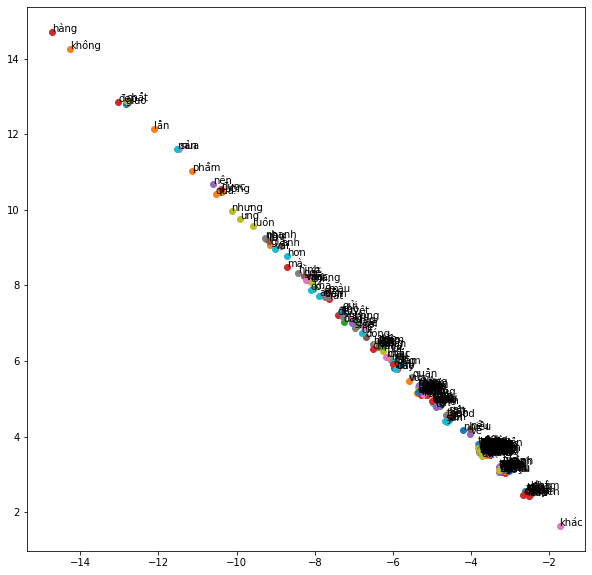

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for word in list(word_id_sub.keys()):
  coord = w2c_my_model.get(word)
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

> **Nhận xét**:
> * Nó hoạt động thật đấy nhưng cũng không tốt cho lắm, rõ ràng ta thấy được có vài từ nằm gần nhau tạo thành cụm - nếu suy ngẫm thì chúng cũng tạo nên những từ ghép có nghĩa. Nhưng ta cũng không thể quá mong đợi rằng nó tốt vì hidden layer của chúng ta chỉ có vỏn vẹn 2 neuron và nếu nhìn vào loss value ta thấy nó tăng dần đều.
> * Tuy nhiên ta cũng có thể khắc phục điều này bằng cách tìm ra một kiến trúc khác phù hợp cho mạng, ta có thể tắng số neuron lên vì 2 neuron là quá ích, sau đó ta có thể sử dụng PCA để chọn ra 2 thành phần quan trọng nhất để trực quan.
> * Đây chỉ là minh họa cho việc ta có thể tự build một word2vec nếu dataset của ta nhỏ. Nhưng tốt nhất ta nên sài những gói mà cộng đồng đã xây dựng sẵn.

Bây giờ, ta sẽ trực quan hóa vectorization dựa vào fasttext lên một không gian 2 chiều. Chúng ta sẽ sử dụng cơ chế PCA của object TSNE sklearn để giảm chiều `ft_vec` thành còn 2 component. Sau đó trực quan hóa chúng để xem với model word2vec của Facebook có tốt trên dataste của chúng ta không.

In [17]:
tsne_2_components = Detective.tsneGetNCompenent(vec_words, 2)
tsne_2_components

,word,freq,ft_vec,label,component_1,component_2
0,thèm,56,"[0.12546667, 0.27063507, -0.3226054, 0.1076125...",0,-6.907181,-42.621933
1,lum,35,"[0.31741396, 0.60768604, -0.23061581, 0.342011...",0,-21.261835,-14.591570
2,tùm,35,"[0.34853685, 0.19606084, -0.22714649, 0.080849...",0,-10.508067,-50.690220
3,huỷ,31,"[0.24349461, 0.12490517, -0.20848149, -0.01994...",0,0.626689,-47.718655
4,đểu,28,"[0.08494775, 0.045489177, -0.035257675, -0.022...",0,16.599503,60.658474
...,...,...,...,...,...,...
3862,spam,2,"[-0.06227298, 0.27240402, -0.012649586, 0.2511...",2,-14.466059,17.413969
3863,cấm,2,"[0.036774382, 0.04028643, -0.031932976, 0.0316...",2,-13.595615,37.167290
3864,thưởng,2,"[0.11008545, 0.026620911, -0.025946898, 0.0367...",2,30.458059,43.333645
3865,hững,2,"[0.04788875, -0.026248291, 0.025058057, 0.0359...",2,-11.566125,53.773468


In [18]:
# visualize
tsne_2_components_shuffle = tsne_2_components.sample(frac=1)
Detective.wordScatterPlot(tsne_2_components_shuffle.head(300))

> **Nhận xét**:
> * Nếu bạn zoom-in vào thì bạn sẽ có thể thấy có những từ về mặt ngữ nghĩa, liên quan với nhau thì chúng thật sự ở gần nhau.
> * Các từ phân bố đều và hợp lí hơn so với model word2vec mà ta tự build.

Tuy nhiên, tôi thấy biểu đồ 2D này còn chưa đủ, đôi khi chúng ta tham vọng hơn và tôi muốn có một góc nhìn trên không gian nhiều chiều nhất mà con người có thể cảm nhận được là 3 chiều. Lúc này thay vì giữ lại 2 trong TSNE, ta sẽ giữ lại 3 component.

In [19]:
tsne_3_components = Detective.tsneGetNCompenent(vec_words, 3)
tsne_3_components

,word,freq,ft_vec,label,component_1,component_2,component_3
0,thèm,56,"[0.12546667, 0.27063507, -0.3226054, 0.1076125...",0,12.590794,-0.150185,-16.671043
1,lum,35,"[0.31741396, 0.60768604, -0.23061581, 0.342011...",0,-0.411150,25.275410,-8.416482
2,tùm,35,"[0.34853685, 0.19606084, -0.22714649, 0.080849...",0,15.421918,1.829494,-28.864141
3,huỷ,31,"[0.24349461, 0.12490517, -0.20848149, -0.01994...",0,-9.550919,12.661244,-28.711575
4,đểu,28,"[0.08494775, 0.045489177, -0.035257675, -0.022...",0,-23.777864,17.612307,29.814354
...,...,...,...,...,...,...,...
3862,spam,2,"[-0.06227298, 0.27240402, -0.012649586, 0.2511...",2,32.405300,12.683109,5.799367
3863,cấm,2,"[0.036774382, 0.04028643, -0.031932976, 0.0316...",2,1.546993,19.951445,25.814106
3864,thưởng,2,"[0.11008545, 0.026620911, -0.025946898, 0.0367...",2,-26.853390,14.487390,15.618331
3865,hững,2,"[0.04788875, -0.026248291, 0.025058057, 0.0359...",2,0.855732,13.552584,42.374588


In [20]:
tsne_3_components_shuffle = tsne_3_components.sample(frac=1)

In [21]:
Detective.word3dPlot(tsne_3_components_shuffle.head(500))

> **Nhận xét**:
> * Với không gian 3 chiều, ta có một cái nhìn cực kì hay ho và thú vị với dataset, nhưng cũng phải nói nó không mạng lại cho ta quá nhiều thông tin, rất có thể ở một không gian nào đó mà chúng sẽ phân cụm một cách tốt hơn, nhưng với giới hạn về mặt thị giác của con người thì chỉ được đến đây.